In [1]:
import pandas as pd
import cStringIO
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
%matplotlib inline

TypeError: 'NoneType' object is not callable

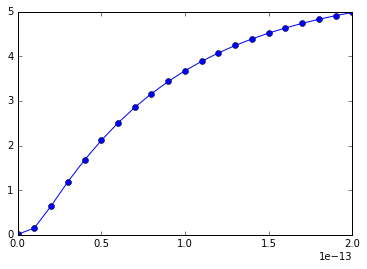

In [63]:
class Parser(object):
    '''Class that can parse a *.plt file. '''
    def __init__(self,filename,spectrum_keys=['SPECTRUM3']):
        self.filename=filename        
        self.list_of_spectrum_keys=spectrum_keys
        self.list_of_datablocks=[]
        self.create_descriptors()
        self.parse_file()

    
    def create_descriptors(self): 
        '''Creates a descriptive dictionary'''
        full_list_of_edits=[]
        full_list_of_times=[]
        self.timesteps_str=[]
        self.edit_name_list=[]
        
        line_index_before=0
        line_diff=0
        line_diff_list=[]       
    
        with open(self.filename) as f:
            for line_index,line in enumerate(f):
                if 'time' in line:
                    full_list_of_times.append(line.split()[3])
                    full_list_of_edits.append(str.join(' ', line.split()[5:]))

        for i in full_list_of_times:
            if i not in self.timesteps_str:
                self.timesteps_str.append(i)
                
        self.timesteps_float=[float(temp) for temp in self.timesteps_str]
                    
        for i in full_list_of_edits:
            if i not in self.edit_name_list:
                self.edit_name_list.append(i)
        
        with open(self.filename) as f:
            for line_index,line in enumerate(f):
                if 'time' in line:
                    #print '{0} found at line {1}'.format(line.split(),line_index)
                    full_list_of_times.append(line.split()[3])
                    full_list_of_edits.append(str.join(' ', line.split()[5:]))
                    for edit_index,edit in enumerate(self.edit_name_list):
                        if edit in line:
                            line_index_diff=line_index-line_index_before
                            line_index_before=line_index
                            line_diff_list.append(line_index_diff)
        
        self.edit_length_list=line_diff_list[1:len(self.edit_name_list)+1]
                
        self.edit_dict_list=[]
        
        for edit_index,edit_name in enumerate(self.edit_name_list):
            if self.edit_name_list[edit_index] in self.list_of_spectrum_keys:
                edit_type='spectral'
            else:
                edit_type='layered'
                self.number_of_layers=self.edit_length_list[edit_index]-3
            edit={'Name':self.edit_name_list[edit_index],'Length':self.edit_length_list[edit_index],'Type':edit_type,'Order':edit_index}
            self.edit_dict_list.append(edit)
    
    def parse_file(self):
        '''Method that aggregates the data from the file'''
        with open(self.filename) as f:
            for line_index,line in enumerate(f):
                line=line.rstrip()
                if line.startswith('#'):
                    time=line.split()[3]
                    edit=str.join(' ', line.split()[5:])
                    self.list_of_datablocks.append(DataBlock(line_index,time,edit))
                elif line.startswith('$'):
                    self.list_of_datablocks[-1].add_descriptor_line(line.strip('$'))
                else:
                    self.list_of_datablocks[-1].add_line(line)

        for datablock in self.list_of_datablocks:
            datablock.cleanup()
                
    def stupid_output(self):
        '''A stupid function that simply print the original file line by line'''
        with open(self.filename) as f:
            for line in f:
                print line
    
    def create_spectrum(self,edit_str,energy_str='sp_energy',int_str='jsp'):
        '''A fucntion that returns an instance of the Spectrum class. '''
        temp_energybin=[]
        temp_intensity=[]
        for datablock_index,datablock in enumerate(self.list_of_datablocks):
            if datablock.edit==edit_str:
                temp_energybin.append(np.array(datablock.df['sp_energy'])[:,0])
                temp_intensity.append(np.array(datablock.df['jsp'])[:,0])
        return Spectrum(np.array(temp_energybin),np.array(temp_intensity),timesteps=self.timesteps_float)
    
    def create_layered_data(self,edit,column_name,layer_index=0,plotkw=None):
        temp_data=[]
        for datablock_index,datablock in enumerate(self.list_of_datablocks):
            if datablock.edit==edit:
                temp_data.append(np.array(datablock.df[column_name])[layer_index])
        return LayeredData(self.timesteps_float,temp_data,layer_index,plotkw=plotkw)    
            
class DataBlock(object):
    '''Datablock for text'''
    def __init__(self,lineindex,time,edit):
        self.lineindex=lineindex
        self.time=time
        self.edit=edit
        self.descriptor_lines=[]
        self.lines=[]
    def add_descriptor_line(self,line):
        '''Add a line that contain column descriptors'''
        self.descriptor_lines.append(line)
    def add_line(self,line):
        '''Add a line that contain actual data'''
        self.number_of_columns=len(line.split())
        self.lines.append(line)
    def cleanup(self):
        '''Method that is run after the whole datablock is saved'''
        self.is_layered_data = 'r' in self.descriptor_lines[0]
        self.one_row_descriptor=self.descriptor_lines[1]==''
        if self.one_row_descriptor:
            a=self.descriptor_lines[0]
            b="\n".join(self.lines)
            string_for_IO="\n".join([a,b])
            v = cStringIO.StringIO()
            v.write(string_for_IO)
            v.seek(0)
            self.df = pd.read_fwf(v)       
        else:
            a="\n".join(self.descriptor_lines)
            b="\n".join(self.lines)
            string_for_IO="\n".join([a,b])
            v = cStringIO.StringIO()
            v.write(string_for_IO)
            v.seek(0)
            self.df = pd.read_fwf(v, header=[0,1])

class Spectrum(object):
    '''Describes one spectrum'''
    def __init__(self,energybin_list,intensity_list,timesteps=None):
        self.energybin_list=energybin_list #a list
        self.energybins=self.energybin_list[0]
        self.intensity_list=intensity_list.T # a list
        #self.energy_range=[min(self.energybins),max(self.energybins)]
        #self.intensity_range=[min(self.intensity),max(self.intensity)]
        self.timesteps=timesteps
    def full_plot(self,material='Unknown',intensity='Unknown',fig=plt.figure()):
        time_fs=np.array(self.timesteps)*1e15
        plt.pcolormesh(time_fs,self.energybins,self.intensity_list,cmap='viridis',norm=LogNorm(vmin=0.1,vmax=self.intensity_list.max()))
        plt.title('{0} at {1}'.format(material,intensity))
        plt.xlabel('Time [fs]')
        plt.ylabel('Energy [eV]')
        plt.cbar=plt.colorbar()
        plt.gca().set_yscale('log')
        return fig
    def diff_plot(self,material='Unknown',intensity='Unknown',fig=plt.figure()):
        time_fs=np.array(self.timesteps)*1e15
        plt.pcolormesh(time_fs,self.energybins,self.intensity_list_diff,cmap='viridis')
        plt.title('{0} at {1}'.format(material,intensity))
        plt.xlabel('Time [fs]')
        plt.ylabel('Energy [eV]')
        plt.cbar=plt.colorbar()
        plt.gca().set_yscale('log')
        return fig    
    def subtract_background(self,spectrum):
        self.intensity_list_diff =  np.subtract(self.intensity_list,spectrum.intensity_list)
        #self.intensity_list_diff =  np.divide(np.subtract(self.intensity_list,spectrum.intensity_list),np.add(self.intensity_list,spectrum.intensity_list))

class LayeredData(object):
    '''Data from a single layer of a simulation. Contains methods for plotting'''
    def __init__(self,timesteps,data,layer_index=None,plotkw={'label':'Unknown'}):
        self.timesteps=timesteps
        self.data=data
        self.layer_index=layer_index
        self.plotkw=plotkw
    def plot_data(self):
        '''Plot the data, returns nothing'''
        title=self.plotkw.pop('title', None)
        plt.plot(self.timesteps,self.data,marker='o',**self.plotkw)
        plt.title(title)
        plt.legend(loc=0)
        plt.xlabel('Time [s]')
        
        
        
class Simulation(object):
    def __init__(self,file_path,material=None):
        self.parser=Parser(file_path)
        self.timesteps=self.parser.timesteps_float
        self.number_of_layers=self.parser.number_of_layers
        self.ion_temp_data=self.parser.create_layered_data('r vs tiv','tiv',plotkw={'title':'Ion T','label':material})
        self.electron_temp_data=self.parser.create_layered_data('r vs tev','tev',plotkw={'title':'Electron T','label':material})
        self.ion_collision_data=self.parser.create_layered_data('r vs tauii','tauii',plotkw={'title':'Tauii','label':material})
        self.ion_data=self.parser.create_layered_data('r vs zbar','zbar',plotkw={'title':'Ionization','label':material})
    def calculate_plasma_parameters(self):
        ne=self.parser.create_layered_data('r vs number_of_e','ne').data[1]
        Te=electron_temp_data.data[1]
        Debye = [7.43e2 * np.sqrt(Te[i]/ne[i]) for i in range(0,np.size(ne))]
        plasma_parameter= [4*np.pi * np.multiply(ne[i],np.power(Debye[i],3)) for i in range(0,np.size(ne))]        
        self.plasma_parameter=LayeredData(self.timesteps,plasma_parameter,plotkw={'title':'Plasma param','label':material})
    def create_spectrum(self):
        self.spectrum=self.parser.create_spectrum('SPECTRUM3')
    
    

my_sim=Simulation('run.plt')
#short=Simulation('../../../../../Software/Emission/Analysis/RAWFROMTINTIN/100-fs/short/ener-7000/fl-1E20/run.plt')
#fig1=plt.figure()
#short.spectrum.full_plot(fig=fig1,material='short')
#water=Simulation('../../../../../Software/Emission/Analysis/RAWFROMTINTIN/100-fs/short_water/ener-7000/fl-1E20/run.plt')
#fig2=plt.figure()
#water.spectrum.full_plot(fig=fig2,material='water')
#short.spectrum.subtract_background(water.spectrum)
#fig3=plt.figure()
#short.spectrum.diff_plot(fig=fig3,material='subtracted')

#short.parser.create_layered_data('r vs tiv','tiv').plot_data()
#plt.figure()
#test=short.parser.create_layered_data('r vs zbar','zbar')
#test.plot_data()
#plt.figure()
#plt.figure()
#short.parser.create_layered_data('r vs tiv','tiv').plot_data()
#plt.figure()
#water.parser.create_layered_data('r vs tiv','tiv').plot_data()

my_sim.ion_temp_data.plot_data()
my_sim.electron_temp_data.plot_data()
#plt.figure()
#my_sim.ion_data.plot_data()
#plt.figure()
#my_sim.spectrum.full_plot()


In [ ]:
plt.show()

In [64]:
water_100fs=Simulation('../../../../../Software/Proposal/100-fs/100fs/ener-6900/fl-1E6/run.plt',material='100 fs water')
salt_100fs=Simulation('../../../../../Software/Proposal/100-fs/100fs_NaI/ener-6900/fl-1E6/run.plt',material='100 fs salt')
water_40fs=Simulation('../../../../../Software/Proposal/100-fs/40fs/ener-6900/fl-1E6/run.plt',material='40 fs water')
salt_40fs=Simulation('../../../../../Software/Proposal/100-fs/40fs_NaI/ener-6900/fl-1E6/run.plt',material='40 fs salt')
sims=[water_100fs,salt_100fs,water_40fs,salt_40fs]

TypeError: 'NoneType' object is not callable

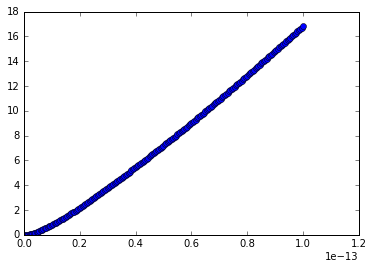

In [65]:
for sim in sims[:2]:
    sim.ion_temp_data.plot_data()
    
plt.figure()
for sim in sims[:2]:
    sim.ion_collision_data.plot_data()


In [ ]:
class Timestep(object):
    '''Describes one timestep'''
    def __init__(self,time,timeindex,**spectrum):
        self.time=time
        self.index=timeindex
        self.list_of_layers=layers
        self.spectrum=Spectrum(**spectrum)

class Spectrum(object):
    '''Describes one spectrum'''
    def __init__(self,energybins,intensity):
        self.energybins=energybins #a list
        self.intensity=intensity # a list
        self.energy_range=[min(energybins),max(energybins)]
        self.intensity_range=[min(intensity),max(intensity)]
        self._clean_spectrum = None
    
class Layer(object):
    '''Describes one layer'''
    def __init__(self,name,composition,average_ionization,energybins,intensity,layer):
        self.name=name
        self.composition=composition
        self.position_index=position_index
        #self.ionization=average_ionization
        #self.temperature=temperature
        self.timestep_it_belongs_to=timestep
        self.Spectrum=Spectrum(energybins,intensity)

class Timestep(object):
    '''Describes one timestep'''
    def __init__(self,time,timeindex):
        self.time=time
        self.line_index=line_index
        self.list_of_layers=layers
        
class Spectrum(object):
    '''Describes one spectrum'''
    def __init__(self,energybins,intensity):
        self.energybins=energybins #a list
        self.intensity=intensity # a list
        self.energy_range=[min(energybins),max(energybins)]
        self.intensity_range=[min(intensity),max(intensity)]
        self._clean_spectrum = None
        
    def return_spectrum(self):
        return self.energybins,self.energy_range
    
    def clean_spectrum(self):
        '''
        EXPENSIVE
        '''            
        if self._clean_spectrum is None:
            r = threshold
            for i in range(100000000000):
                r += i
            self._clean_spectrum = r
        else:
            return self._clean_spectrum
        
    def wash_spectrum(self):
        '''
        EXPENSIVE
        '''
        if not hasattr(self, "_wash_spectrum"):
            r = sum(range(10000000))
            self._wash_spectrum = r
        return self._wash_spectrum
        
    def calculate_spectrum(self,background_spectrum=None,method='subtract'):
        self.background_spectrum=background_spectrum
        if method==subtract:
            self.spectrum=self.spectrum-self.background_spectrum
            return
        else:
            print 'No background correction done'
            return

class SpectrumPlot(object):
    '''
    A plot that describes spectral data
    '''
    def __init__(self,spectrum,ranges):
        self.spectrum=spectrum
        self.ranges=ranges
    def create_heat_panel(self):
        pass
    def create_sum_panel(self):
        pass
    def show_composite_plot(self):
        pass            